# Multimodal Distances Tool Py

# Info documents

This tutorial can be used to compare multiple annotations in ELAN (Wittenburg et al., 2006) using the multimodal-annotation-distance tool. It requires an annotated file in ELAN (.eaf) format and outputs a table with the reference tier and the compared tiers.

The tool multimodal-annotation-distance can be pulled from: <https://github.com/JorgeFCS/multimodal-annotation-distance.git>

To cite the tool: Barros, C. A., Ciprián-Sánchez, J. F., & Santos, S. M. (2024). A Tool for Determining Distances and Overlaps between Multimodal Annotations. In N. Calzolari, M.-Y. Kan, V. Hoste, A. Lenci, S. Sakti, & N. Xue (Eds.), *Proceedings of the 2024 Joint International Conference on Computational Linguistics, Language Resources and Evaluation (LREC-COLING 2024)* (pp. 1705–1714). ELRA and ICCL. https://aclanthology.org/2024.lrec-main.150

## Multimodal annotation tools

The multimodal-annotation-distance tool allows you to use a tier as a reference to compare other tiers and how they are displaced in time regarding one to another. The following scheme indicates reference and comparison tiers.

In a annotation, we can have the following structure:
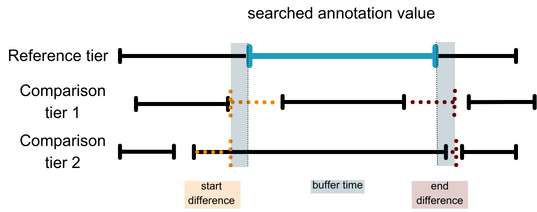

The tool will provide the time displacement between the onsets and offsets of each boundary of the reference tier to the comparison tiers, shown in the dotted lines. Each one of this tiers can be defined by the user, as well as if this comparison should account for the span of the reference tier (*span comparison*) or only the points in time of the offsets (*point comparison*).

We will use the span comparison in this tutorial. The *span comparison* takes the time spans of each annotation tier into consideration, comparing the values of the boundaries of the reference tier (bold line in blue) to the onset and offset values of one or more compared tiers (dotted lines in orange and red). Looking at these boundaries, it is possible to infer whether the comparison tiers start before or after a given tier, how much they overlap (ratio), and the duration of the corresponding tiers. A time buffer can be used to determinate if reference and comparison tiers can be considered as co-occurring even when not exactly overlapping.

In case you want to use the *point comparison*, you should have in mind that this function searches for the offset of the reference tier and outputs the closest match in the compared tiers. It is specially designed to analyze items that do not have a span in time, such as apexes or pitch accents (when considered points in time).

It is important to highlight that this tool was created to compare tiers, but it is not a validation tool for the transcriptions or a way to see inter-rater reliability measures. It is rather an enhancement to the *pympi* package (Lubbers and Torreira (2013-2021), as it allows comparison with different tier types (including symbolic).

### Basic validation previous to use

This tool can be used for a single file as well as for a batch. If you are using it for a batch, be sure that all files have the *exact* same tier name taken into consideration, otherwise it will fail. The media files will not be used at all.

## BGEST - case study

In this case study, we will look in the BGEST Corpus (Barros, 2021) to see how gesture phrases and strokes synchronize to non terminal prosodic units of Parentheticals. So we looked at the reference tier *InfoStructure* for the searched annotation value *PAR*, and compared to the tiers *GE-Phrase* and *GE-Phase*. All this information is in the `config_example_span.ini` file.

### Setting up the config.ini file

The configuration file indicates which tiers you want to compare and how do you want to compare them. It requires following information:

\- Path of the directory containing the .eaf files to analyze.

\- Path to the directory in which to save the results.

\- Name of the results file with extension (e.g., results.csv)

\- Reference tier against to which we want to perform the comparison.

\- Value in the reference tier to search for.

\- Mode of operation. Either `span` or `point_comparison`

\- Buffer time in ms (if you do not want a buffer time, use 0)

\- Tiers to compare against the reference tier.

\- Enter the comparison tiers separated by commas (e.g.: tier1,tier2) -- but no space between them

### Usage

Considering that you are running this in R Studio, the first step is to install the requirements and run the tool in the Terminal tab (this tab is next to the console, on the bottom of the screen). Before running the lines below, make the following steps: 1. Clone the repository from <https://github.com/JorgeFCS/multimodal-annotation-distance.git> 2. Set the directory to the folder containing the multimodal_annotation_distance.py file 3. Install the requirements in R Studio terminal tab 4. Run the tool using the command line below:


In [3]:
## go to cmd to run config.ini file
import os

current_directory = os.getcwd()

In [ ]:
# STEP 1: clone repository
# STEP 2: set the directory to the folder containing the multimodal_annotation_distance.py file
# STEP 3: assuming you are using R Studio, run the following lines in the terminal tab
## installing requirements
%cd multimodal-annotation-distance
!pip install -r requirements.txt

## running multimodal-distance-tool at the terminal -- it can take a bit to run ##
!python multimodal_annotation_distance.py --config-file-path ./config_example_span.ini


### Data exploration

First, import the dataset.

In [5]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from scipy.stats import shapiro
from scipy.stats import pearsonr

# Load datasets
span_PAR = pd.read_csv("bgest_spancomparison.csv")
# It does not directly outputs the data in tidy format. 


The dataset for the *span comparison* should look like this, with following values:

1.  InfoStructure_PAR_start_ms: onset of the searched annotation value on the reference tier in milliseconds;

2.  InfoStructure_PAR_end_ms: offset of the searched annotation value on the reference tier in milliseconds;

3.  InfoStructure_PAR_duration: duration of the searched annotation value on the reference tier in milliseconds. It is calculated as follows:\
    `ref_tier_duration = (ref_tier_end + buffer) - (ref_tier_start - buffer)`

4.  Buffer_ms: assigned buffer time;

5.  Tier: compared tier, ordered first by relation to reference tier then by time;

6.  Value: annotation values for each unit in the compared tiers;

7.  Begin_ms: onset of the compared tier for each annotation value (listed in item 6);

8.  End_ms: offset of the compared tier for each annotation value (listed in item 6);

9.  Duration: duration of the compared tier for each annotation value (listed in item 6). It is obtained as follows:\
    `comparison_tier_duration = comparison_tier_end - comparison_tier_start`

10. Overlap_time: provides the time in milliseconds for all cases in which there is an overlap between the reference tier and the compared tier and is calculated as follows:\
    `overlap = min((ref_tier_end + buffer)/ comparison_tier_end) - max((ref_tier_start - buffer), comparison_tier_start)`

11. Overlap_ratio: provides the proportion of the overlap time (rounded to three decimal places) in relation to the length of the reference value and is obtained as follows:\
    `overlap_ratio = overlap_time / ref_tier_duration`

12. Diff_start: provides the starting time of the comparison tier in relation to the start of the reference value as follows:\
    `diff_start = (ref_tier_start - buffer) - comparison_tier_start`\
    For *diff_start*, a positive value means that the unit on the compared tier starts before the unit on the reference tier (considering the buffer time). A negative value means that the unit on the compared tier starts after the unit on the reference tier (considering the buffer time). Null values means that they match perfectly.

13. Diff_end: provides the ending time of the comparison tier in relation to the end of the reference value as follows:\
    `diff_end = (ref_tier_end + buffer) - comparison_tier_end`\
    For the *diff \_end*, a positive value means that the unit on the compared tier ends before the unit on the reference tier (considering the buffer time). A negative value means that the unit on the compared tier ends after the unit on the reference tier (considering the buffer time). Null values means that they match perfectly.

As points cannot overlap with another unit, the mode *point comparison* of comparison outputs only the values (1) to (9).


In [6]:
## inspecting the dataframe
span_PAR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40768 entries, 0 to 40767
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   InfoStructure_PAR_start_ms  40768 non-null  int64  
 1   InfoStructure_PAR_end_ms    40768 non-null  int64  
 2   InfoStructure_PAR_duration  40768 non-null  int64  
 3   Buffer_ms                   40768 non-null  int64  
 4   Tier                        40768 non-null  object 
 5   Value                       40768 non-null  object 
 6   Begin_ms                    40768 non-null  int64  
 7   End_ms                      40768 non-null  int64  
 8   Duration                    40768 non-null  int64  
 9   Overlap_time                40768 non-null  int64  
 10  Overlap_ratio               40768 non-null  float64
 11  Diff_start                  40768 non-null  int64  
 12  Diff_end                    40768 non-null  int64  
dtypes: float64(1), int64(10), objec

#### Pre-processing

It might require some pre-processing, such as mislabeled data or duplicates.

In [7]:
# Pre-processing
# Replace "hold" with "stroke hold" for consistency
span_PAR["Value"] = span_PAR["Value"].replace("hold", "stroke hold")

# Fix duplicates
span_nodup = span_PAR.drop_duplicates()

## Data Analysis

### Dispersion

Now that the data is clean of duplicates, we can focus on the analysis. We want to check how the overlap ratio, i.e., the amount of overlap that strokes and gesture phrases have with informational unit. The informational unit is delimited in this dataset as non terminated units.

In [8]:
# Dispersion
# Gesture phrase dispersion
dispersion_phrase = span_nodup[span_nodup["Tier"] == "GE-Phrase"].groupby("Tier").agg(
    Total=("Value", "count"),
    CST_M=("Diff_start", "median"),
    CST_SD=("Diff_start", np.std),
    CET_M=("Diff_end", "median"),
    CET_SD=("Diff_end", np.std)
)

# Stroke dispersion
dispersion_stroke = span_nodup[span_nodup["Tier"] == "GE-Phase"].groupby("Value").agg(
    Total=("Value", "count"),
    CST_M=("Diff_start", "median"),
    CST_SD=("Diff_start", np.std),
    CET_M=("Diff_end", "median"),
    CET_SD=("Diff_end", np.std)
)

dispersion_combo = pd.concat([dispersion_phrase, dispersion_stroke])
print(dispersion_combo)

             Total  CST_M       CST_SD  CET_M       CET_SD
GE-Phrase      131  306.0  1178.784939 -266.0  1117.386280
preparation     55 -190.0   731.120830  151.0   655.008069
retraction      46 -386.5   665.310946  157.5   667.886819
stroke          85   -2.0   891.311666  278.0   948.343719
stroke hold     14 -425.0   754.864346  333.0   641.598386


In this dispersion table we can understand if the compared tier annotations, gesture phrases and strokes, start after or before the reference tier selected annotation. As CST_M is positive and CET_M is negative, we can infer that the gesture phrase tends to start before and to end after the Parenthetical unit. The stroke, on the other hand, has the opposite pattern, which makes sense as it is included in the gesture phrase.

What we can also state from those values is they show high variance, as all standard deviations are above 640ms. In comparison to the informational unit studied, PAR, which has a median duration of 1250ms (SD= 547.95). This indicates that there is variation that can span up to half of the analyzed unit and three times the value of 200 ms normally assumed in the literature (Loehr, 2004) as a degree of mismatch between a prosodic and a gestural event.

### Visualizing overlap ratio and centered starting times

Another way to see this is to plot a scatterplot that takes the starting time of the comparison tiers (centered values) by the overlap ratio (Figure 2). The thought behind this is that the higher the overlap, the tighter is the connection between the reference tier and comparison tier. Here the dispersion is color coded regarding the gesture phrase (blue) and strokes (orange). Althought the different distributions, they have similar tendencies, as shown in the regression line supperimposed in the graph.


<Axes: xlabel='Overlap_ratio', ylabel='Diff_start'>

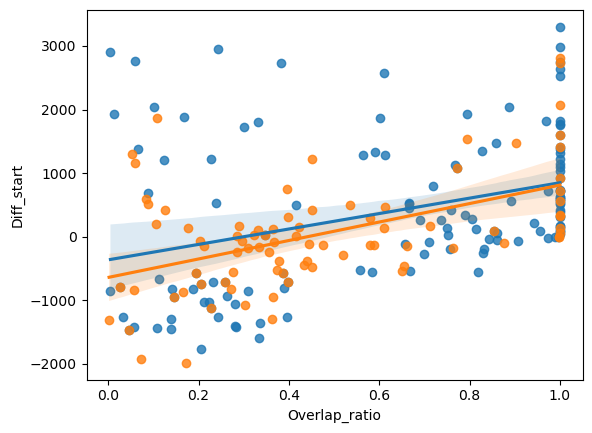

In [9]:
# Visualizing overlap ratio and centered starting times for gesture phrases and strokes
span_gephrase = span_nodup[span_nodup["Tier"] == "GE-Phrase"]
sns.regplot(x=span_gephrase["Overlap_ratio"], y=span_gephrase["Diff_start"])

span_stroke = span_nodup[span_nodup["Value"] == "stroke"]
sns.regplot(x=span_stroke["Overlap_ratio"], y=span_stroke["Diff_start"])

### Correlation of alignment of onsets and overlap ratio for gesture phrase and strokes

What occurs with the onset alignment of PAR and the gesture-phrase containing the stroke? It would seem logical to assume that if a gesture-phrase overlaps more with PAR, it would also overlap more with its corresponding stroke.

Looking at gesture-phrases that contain the stroke in relation to the overlap ratio relative to PAR, there is only a weak correlation of the onset alignment of PAR and the gesture phrase. Although the correlation's direction aligns with our expectations (higher the overlap, smaller the centered onset time), its strength does not. As indicated in Table 1, gesture phrases often begin before and end after the overlapping PAR unit. This trend can be examined by referring to Figure 3.

<Axes: xlabel='Overlap_ratio', ylabel='Diff_end'>

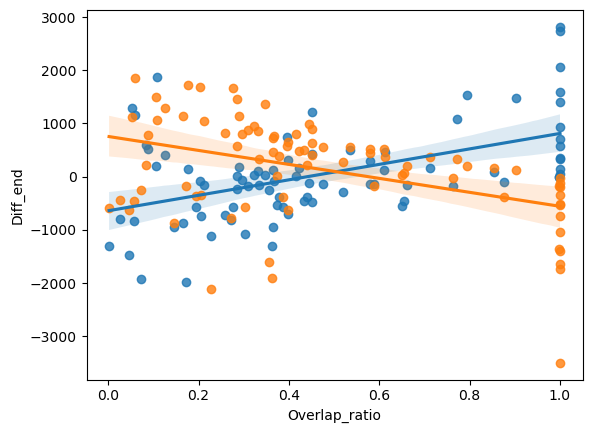

In [10]:
# Correlation of alignment of onsets and overlap ratio for gesture phrases and strokes
sns.regplot(x=span_stroke["Overlap_ratio"], y=span_stroke["Diff_start"])
sns.regplot(x=span_stroke["Overlap_ratio"], y=span_stroke["Diff_end"])

## Discussion points

One lingering question persists: what degree of overlap signifies coordination between a gesture-phrase and the IU? For gesture-phrases, the answer appears straightforward: nearly all gesture-phrases that start before PAR's onset can be distinguished by a 50% overlap ratio (1st quadrant of Figure 2). However, this pattern is less evident for strokes. It would be intriguing to assess the alignment of strokes (or their central points) with lower-level prosodic events. This investigation could shed light on why apexes tend to correlate with pitch accents. Nonetheless, this does not necessarily imply the necessity of a time buffer to establish synchronicity.

In conclusion, PAR appears to prompt some level of coordination between gesture and speech boundaries, suggesting that the assumption of phonological synchronicity arising from semantic/pragmatic synchronicity might hold true. It's also noteworthy that while existing literature suggests the need for a buffer time to analyze speech-to-gesture coordination, the data presented thus far have not incorporated any buffer. We contend that the dispersion of boundaries is better elucidated in terms of the overlap ratio rather than relying on a buffer time, which could introduce arbitrary elements into the analysis. For a more in-depth discussion of the data presented here, please refer to Barros et al. (2024).



## References

1.  Wittenburg, Peter; Brugman, Hennie; Russel, Albert; Klassmann, Alex; Sloetjes, Han. 2006. Elan: a professional framework for multimodality research. In *Proceedings of LREC 2006*, pages 1556--1559. Max Planck Institute for Psycholinguistics, The Language Archive, Nijmegen. [Online; accessed 2020-03-07].
2.  Barros, Camila A. (2021). A relação entre unidades gestuais e quebras prosódicas: o caso da unidade\
    informacional parentético. Unpublished MA Thesis at Universidade Federal de Minas Gerais.
3.  D.P. Loehr. 2004. Gesture and intonation. Ph.D. thesis, Georgetown University, Georgetown.
4.  Lubbers, Mart; Torreira, Francisco. (2013-2021). *pympi-ling*: a python module for processing elans eaf\
    and praats textgrid annotation files. <https://pypi.python.org/pypi/pympi-ling>. Version 1.70.
5.  Barros, C. A., Ciprián-Sánchez, J. F., & Santos, S. M. (2024). A Tool for Determining Distances and Overlaps between Multimodal Annotations. In N. Calzolari, M.-Y. Kan, V. Hoste, A. Lenci, S. Sakti, & N. Xue (Eds.), *Proceedings of the 2024 Joint International Conference on Computational Linguistics, Language Resources and Evaluation (LREC-COLING 2024)* (pp. 1705–1714). ELRA and ICCL. https://aclanthology.org/2024.lrec-main.150